## 課題提出時（2018/12/1）の所感
バックワードの実装はイメージが出来なくて、また締め切り時間も迫っていたため断念しました。ただ、フォワード処理（畳み込み層とプーリング層）については、おおよその処理のイメージを体得出来たのではないかと思います。何度も入力特徴マップ、フィルタ、出力特徴マップを紙に書き出して手計算をひたすら繰り返して、実装とのチェックを行ったことが、遠回りしているようで一番の理解の近道だったと思います。有意義なSprintであったと思います。

<出来なかったこと>  
・バックフォワード処理（畳み込み層・プーリング層）  
・平滑化  
・LeNetのスクラッチ  
・平均プーリングの作成

### 1.この課題の目的
・スクラッチを通してCNNの基礎を理解する  
・基本的なCNNのキーワードを学習する  
・初期の有名なCNNモデルを知る  

【目的としないこと】  
・実用的なCNNモデルに関する知識の習得  

### 2.進め方
・CNNをスクラッチで実装する。（1日目〜2日目）  
・手法の説明を記述する。（2日目夜発表）  

### 3.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。TensorFlowなどは使用しない。

sprint12では1次元畳み込み層を実装したが、sprint13では画像に対して一般的に使われる2次元畳み込み層を実装する。また、プーリング層なども作成することで、CNNの基本形を完成させる。



## データセットの用意

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
import numpy as np

# 保存先を指定
mnist_dir = "/Users/tsuneo/git/diveintocode-term2/mnist_data"

# 保存
mnist = fetch_mldata("MNIST original", data_home=mnist_dir)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2, shuffle=False)

# データタイプを確認
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# データ件数も確認する
print(X_train.shape, X_test.shape)


uint8 uint8 float64 float64
(56000, 784) (14000, 784)


In [2]:
# 正解ラベルについて、floatをintへ変更しておく
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

# 再度データタイプを確認
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

uint8 uint8 int64 int64


In [3]:
# 前処理
# 特徴量だけをfloatへ変換する
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

# 再度データタイプを確認
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

float64 float64 int64 int64


In [4]:
# 正規化？正則化？標準化？をする

print(X_train.max())
print(X_train.min())
print("----")
X_train = X_train / 255
X_test = X_test / 255

print(X_train.max())
print(X_train.min())

255.0
0.0
----
1.0
0.0


In [5]:
# 訓練データを検証用データに分割する
X_train, X_val, y_train ,y_val = train_test_split(X_train, y_train,test_size=0.2, shuffle=False)


In [6]:
# データ件数も確認する
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(44800, 784) (11200, 784) (14000, 784)
(44800,) (11200,) (14000,)


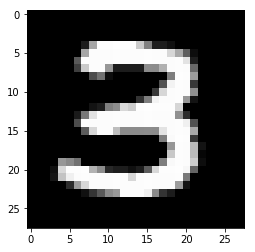

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
image=X_train[22339].reshape(28,28)
plt.imshow(image,'gray')
plt.show()

# Conv2dクラスを実装しました

In [8]:
import numpy as np

class Conv2d:
    def __init__(self):
        # 高さ/幅方向の入力サイズ（特徴量の数）
        self.Nh_in = None
        self.Nw_in = None
        
        # 高さ/幅方向のパディングの数
        self.Ph = None
        self.Pw = None
        
        # 高さ/幅方向のフィルダサイズ
        self.Fh = None
        self.Fw = None
        
        # 高さ/幅方向のストライドのサイズ
        self.Sh = None
        self.Sw = None

        # 高さ/幅方向の出力サイズ（特徴量の数）
        self.Nh_out = None
        self.Nw_out = None
        
        # バイアス
        self.bias = 1
        

    def _output_size(self, X, F):
        
        # チャンネル数の取得。フィルタのチャンネル数は同じ前提なのでXだけで見れば良い
        self.Chan = X.shape[1]
        
        # 高さ/幅方向の入力サイズ（入力特徴量の数） 4次元（データ数、チャンネル数、高さ、幅）チャンネルを想定
        self.Nh_in = X.shape[2] 
        self.Nw_in = X.shape[3]

        # 高さ/幅方向のフィルタサイズ 4次元（データ数、チャンネル数、高さ、幅）チャンネルを想定
        self.Fh = F.shape[2]
        self.Fw = F.shape[3]
        
        # 高さ/幅方向のパディングの数
        self.Ph = 0
        self.Pw = 0
        
        # 高さ/幅方向のストライドのサイズ
        self.Sh = 1
        self.Sw = 1

        # 高さ方向の出力サイズ（出力特徴量の数）
        self.Nh_out = ((self.Nh_in + 2*self.Ph - self.Fh)/self.Sh)+1
        self.Nh_out = int(self.Nh_out)
        
        # 幅方向の出力サイズ（出力特徴量の数）
        self.Nw_out = ((self.Nw_in + 2*self.Pw - self.Fw)/self.Sw) + 1
        self.Nw_out = int(self.Nw_out)
        
        
    def forward(self, X, F):
        
        # まず始めに、畳み込み後の出力サイズを算出する
        self._output_size(X, F)
                
        # 出力特徴マップを最後にまとめる枠
        S = np.zeros([self.Chan, self.Nh_out, self.Nw_out])
        
        # チャンネルのループ
        for c in range(self.Chan):
            
            # 畳み込み後の出力特徴マップの枠を作成&初期化
            # チャンネルが変わる毎に初期化（ゼロリセット）が必要
            A = np.zeros([self.Chan, self.Nh_out, self.Nw_out])
            
            # 行方向のループ
            for i in range(self.Nh_out):

                # 列方向のループ
                for j in range(self.Nw_out):
                    A[c,i,j]= np.sum(X[0][c][i : self.Fh+i, j : self.Fw+j] * F[0][c]) + self.bias
                    A = A.astype(np.int)
            
            S[c] = S[c] + A[c]
            S = S.astype(np.int)
        
        # 最後にチャンネル毎に合計する変数「S_sum」を作って、
        # for文で足しているが、for文を使わないでNumPyで簡単にできる方法があるような
        # 気がするが今は前に進めることを重視してfor文で対応した
        S_sum = np.zeros([self.Nh_out, self.Nw_out])
        
        for c in range(self.Chan):
            S_sum = S_sum+S[c]
        
        S_sum = S_sum.astype(np.int)
        
        return S_sum
    
    # backwardはタイムオーバーかつ、実装イメージが固まらなかったため作成しておりません
    # ただ、どこかでチェレンジしたいと考えております。
    def backward(self):
        pass

### MNISTでテストする前に自前のサンプルデータで確認

In [9]:
# 3チャンネルの入力データを手作り　４次元（1,3,4,4） ,
X = np.array([[[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]],[[2,2,2,2],[2,2,2,2],[2,2,2,2],[2,2,2,2]],[[3,3,3,3],[3,3,3,3],[3,3,3,3],[3,3,3,3]]])
# 3チャンネルのフィルター手作り(1,3,3,3)
F = np.array([[[1,1,1],[1,1,1],[1,1,1]],[[2,2,2],[2,2,2],[2,2,2]],[[3,3,3],[3,3,3],[3,3,3]]])

# 次元を増やすテクニック（後ろに追加してたことはあるが、前にも追加できる！！）
X = X[np.newaxis, :, :, :]
F = F[np.newaxis, :, :, :]

print("次元確認　　：",X.shape, F.shape)


次元確認　　： (1, 3, 4, 4) (1, 3, 3, 3)


In [10]:
# インスタンス化＆フォワード処理
# 手計算の値と一致していることを確認
model = Conv2d()
print(model.forward(X, F))

[[129 129]
 [129 129]]


In [11]:
# 3チャンネルデータを手作り（1,3,5,5）
X = np.array([[[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]],[[2,2,2,2,2],[2,2,2,2,2],[2,2,2,2,2],[2,2,2,2,2],[2,2,2,2,2]],[[3,3,3,3,3],[3,3,3,3,3],[3,3,3,3,3],[3,3,3,3,3],[3,3,3,3,3]]])
# 3チャンネルのフィルター手作り(1,3,2,2)
F = np.array([[[1,1],[1,1]],[[2,2],[2,2]],[[3,3],[3,3]]])

# 次元を増やすテクニック（後ろに追加してたことはあるが、前にも追加できる！！）
# 4次元データに拡張する
X = X[np.newaxis, :, :, :]
F = F[np.newaxis, :, :, :]

print("次元確認　　：",X.shape, F.shape)


次元確認　　： (1, 3, 5, 5) (1, 3, 2, 2)


In [12]:
# インスタンス化＆フォワード処理
# 手計算の値と一致していることを確認
model1 = Conv2d()
print(model1.forward(X, F))
print(model1.forward(X, F).shape)

# プーリング層に入れるために、次元を2次元から4次元に拡張させる
to_Pooling = model1.forward(X, F).reshape(1,1,4,4)
print(to_Pooling.shape)

[[59 59 59 59]
 [59 59 59 59]
 [59 59 59 59]
 [59 59 59 59]]
(4, 4)
(1, 1, 4, 4)


### 手作りデータではなく、MNISTデータでチャレンジしてみる
### そして、畳み込み後の出力特徴マップをビジュアルで確認してみた
### フィルタにより変化していることがわかり、試してみて面白かったです

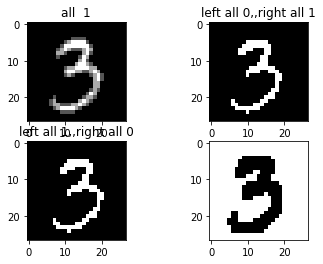

In [13]:
# 手作りデータではなく、MNISTデータでチャレンジしてみる
model2 = Conv2d()

# 次元拡張
b = X_train[20000:20002].reshape(2,1, 28, 28)

# フィルタは手作り。いろんなパターンを試してみる
# 1チャンネル目しか利用しないので、そこだけ変更しています
F2_1 = np.array([[[1,1],[1,1]],[[2,2],[2,2]],[[3,3],[3,3]]])
F2_2 = np.array([[[0,1],[0,1]],[[2,2],[2,2]],[[3,3],[3,3]]])
F2_3 = np.array([[[1,0],[1,0]],[[2,2],[2,2]],[[3,3],[3,3]]])
F2_4 = np.array([[[0,-0.5],[0,-0.5]],[[2,2],[2,2]],[[3,3],[3,3]]])

# 次元拡張
F2_1 = F2_1[np.newaxis, :, :, :]
F2_2 = F2_2[np.newaxis, :, :, :]
F2_3 = F2_3[np.newaxis, :, :, :]
F2_4 = F2_4[np.newaxis, :, :, :]

# フォワード処理
test2_1 = model2.forward(b, F2_1)
test2_2 = model2.forward(b, F2_2)
test2_3 = model2.forward(b, F2_3)
test2_4 = model2.forward(b, F2_4)

# print("F2のシェイプ：",F2.shape)
# print("畳み込み後のshape  :",test2_1.shape)

# 描画
plt.subplot(2,2,1)
plt.title("all  1")
plt.imshow(test2_1,'gray')

plt.subplot(2,2,2)
plt.title("left all 0,,right all 1")
plt.imshow(test2_2,'gray')

plt.subplot(2,2,3)
plt.title("left all 1,,right all 0")
plt.imshow(test2_3,'gray')

plt.subplot(2,2,4)
plt.title("")
plt.imshow(test2_4,'gray')

plt.show()

### 次に最大値プーリング層に挑戦する

In [14]:
# 次に最大値プーリング層に挑戦する
class MaxPool2D:
    def __init__(self):
        
        # チャンネルの初期値
        self.Chan = None
        
        # 高さ/幅方向の入力サイズ（特徴量の数）
        self.Nh_in = None
        self.Nw_in = None
                
        # 高さ/幅方向のストライドのサイズ
        self.Sh = None
        self.Sw = None

        # 高さ/幅方向の出力サイズ（特徴量の数）
        self.Nh_out = None
        self.Nw_out = None        

    def _output_size(self, X, Pool):
        
        # Poolはプーリングウィンドウのサイズ（2,2）の場合は2のスカラー値として
        # パラメータを受け取る想定
        
        # チャンネル数の取得
        self.Chan = X.shape[1]
        
        # 高さ/幅方向の入力サイズ（入力特徴量の数） 4次元（データ数、チャンネル数、高さ、幅）チャンネルを想定
        self.Nh_in = X.shape[2] 
        self.Nw_in = X.shape[3]
                        
        # 高さ/幅方向のストライドのサイズ
        # プーリングウィンドウと同じストライドとしてみた
        self.Sh = Pool
        self.Sw = Pool

        # 高さ方向の出力サイズ（出力特徴量の数）
        self.Nh_out = ((self.Nh_in - Pool)/self.Sh)+1
        self.Nh_out = int(self.Nh_out)
        
        # 幅方向の出力サイズ（出力特徴量の数）
        self.Nw_out = ((self.Nw_in - Pool)/self.Sw) + 1
        self.Nw_out = int(self.Nw_out)
        
        
    def forward(self, X, Pool):
        
        # まず始めに、プーリング後の出力サイズを算出する
        # Poolはプーリングウィンドウのサイズのスカラー値。（3,3）の場合は→3
        self._output_size(X, Pool)
        
        #print(self.Nh_out, self.Nw_out)
        #print(self.Chan)
                
        # 出力特徴マップを最後にまとめる枠
        S = np.zeros([self.Chan, self.Nh_out, self.Nw_out])
        
        # チャンネルのループ
        for c in range(self.Chan):
            #print("c   :   ",c)
            
            # 畳み込み後の出力特徴マップの枠を作成&初期化
            # チャンネルが変わる毎に初期化（ゼロリセット）が必要
            A = np.zeros([self.Chan, self.Nh_out, self.Nw_out])
            
            # 行方向のループ
            for i, i_h in enumerate(range(0, self.Nh_in, Pool)):

                # 列方向のループ
                for j, j_w in enumerate(range(0, self.Nw_in, Pool)):
                    A[c,i,j]= np.amax(X[0][c][i_h : Pool+i_h, j_w : Pool+j_w])
                    
                    # backwardするためにの準備してました。途中ですが消さずに残しておきます
                    # index = np.unravel_index(X[0][c][i_h : Pool+i_h, j_w : Pool+j_w])
                
            S[c] = A[c]
                    
        S = S.astype(np.int)
                
        return S

    # 畳み込み同様にバックワードはギブでした
    def backward(self):
        pass

### MNISTでテストする前に自前のサンプルデータで確認

In [15]:
# Poolingするデータを手で作成した
X = np.array([[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]],[[17,18,19,20],[21,22,23,24],[25,26,27,28],[29,30,31,32]],[[33,34,35,36],[37,38,39,40],[41,42,43,44],[45,46,47,48]]])
X = X[np.newaxis, :, :, :]
X.shape

(1, 3, 4, 4)

In [16]:
# 手計算と同じであることを確認できた
mp = MaxPool2D()
mp.forward(X,2)

array([[[ 6,  8],
        [14, 16]],

       [[22, 24],
        [30, 32]],

       [[38, 40],
        [46, 48]]])

### 手作りデータではなく、畳み込み済みMNISTデータでチャレンジしてみる

In [17]:
# 畳み込みしたデータをMaxPoolingしてみる
test2_1.shape
test2_1  =test2_1[np.newaxis, np.newaxis, : , :]

In [18]:
mp2 = MaxPool2D()
conv_to_pool = mp2.forward(test2_1,3)
print(conv_to_pool)
print(conv_to_pool.shape)

[[[1 1 1 1 1 1 1 1 1]
  [1 1 1 3 4 4 1 1 1]
  [1 1 3 4 4 4 1 1 1]
  [1 1 2 1 4 4 1 1 1]
  [1 1 1 4 4 4 4 1 1]
  [1 1 1 1 1 1 4 1 1]
  [1 1 2 1 1 4 3 1 1]
  [1 1 3 4 4 4 1 1 1]
  [1 1 1 2 2 1 1 1 1]]]
(1, 9, 9)


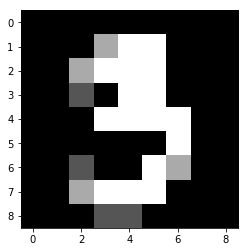

In [19]:
# 描画してみる
# 情報が削減されて、荒いデータとなっていることが分かる
conv_to_pool_new = conv_to_pool.reshape(9,9)
conv_to_pool_new.shape
plt.imshow(conv_to_pool_new,'gray')
plt.show()

In [20]:
# 手計算データのプーリング
mp1 = MaxPool2D()
mp1.forward(to_Pooling,2)

array([[[59, 59],
        [59, 59]]])

# 説明
**・畳み込み層とは何か**  
フィルタ（カーネル）というNNでいう所の重みパラメータを用意して、入力画像（特徴マップ）のまま縦横にサーチして新たな出力特徴マップを作成する層です。NNと同様にバイアスも存在し、フィルター1つに１つあります。


**・プーリング層とは何か**  
畳み込み層=>活性化関数層を経て、Pooling層で処理を行いますが、3×3などのウィンドウを用意して、入力特徴マップをサーチして、最大値（や平均値）の値を抽出して新たな出力特徴マップを作成する層のことです。

**・CNNは全結合層のみのニューラルネットワークとどのように違うか**  
全結合のニューラルネットワークで、MNISTを分類しましたが、２次元画像としてモデルに読み込んでいません。28×28をFlattenして784の１列に引き伸ばしたデータを入力として使っています。これは２次元画像が本来保持している縦横関係性を完全に無視しています。その課題を解決策として畳み込み層があります。縦横のフィルタ（カーネル）を用意して入力画像を縦横のままサーチして出力特徴マップを作成します。こうすることで、縦横の関係性も学習することができることが大きな違いです。



## 出力サイズとパラメータ数の計算

In [21]:
# H     :入力サイズ  
# W    :入力サイズ
# P     : パディング 
# FH   : フィルターサイズ
# FW  : フィルターサイズ
# S     : ストライド

# OH   : 出力サイズ
# OW  : 出力サイズ
def pram_cal(H, W, P, FH, FW,S):
    OH = ((H + 2*P - FH)/S) + 1
    OW = ((W + 2*P - FW)/S) + 1
    return int(OH), int(OW)

In [22]:
# 1
print("出力サイズ：",pram_cal(H=144, W=144, P=0, FH=3, FW=3, S=1))
print("パラメータ数：",(3*9*6)+6)

出力サイズ： (142, 142)
パラメータ数： 168


In [23]:
# 2
print("出力サイズ：",pram_cal(H=60, W=60, P=0, FH=3, FW=3, S=1))
print("パラメータ数：",(24*9*48)+48)

出力サイズ： (58, 58)
パラメータ数： 10416


In [24]:
# 3
print("出力サイズ：",pram_cal(H=20, W=20, P=0, FH=3, FW=3, S=2))
print("パラメータ数：",(10*9*20)+20)

出力サイズ： (9, 9)
パラメータ数： 1820


## フィルタサイズ
畳み込み層にはフィルタサイズというハイパーパラメータがあるが、2次元畳み込み層において現在では3×3と1×1の使用が大半である。以下のそれぞれを調べたり、自分なりに考えて説明せよ。

7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
高さや幅方向を持たない1×1のフィルタの効果

**【回答】**  
調べても「これ」というものが見つからなかったので、自分の考えとなりますが、フィルタサイズが大きいと、出力特徴マップが小さくなり過ぎてしまい、入力データが本来保持している情報が薄まってしまうからだと思います。間違っている場合は訂正いただきたいです。

## 1次元と2次元畳み込みの違い
sprint12で扱った1次元畳み込み層と、sprint13で扱った2次元畳み込み層はどのように違うか説明せよ。以下の点を含める。

・利用される場面・データ  
・実装上の変化  

**【回答】**  
実装上の変化は、1次元畳み込みの場合は縦方向のループを回す必要がありませんでしたが、2次元の場合はそこを考慮する必要があることです。  

１次元畳み込みが利用される場面ですが、以下のサイトで歩行者検出手法を提案されている資料が見つかりました。
http://www.vision.cs.chubu.ac.jp/MPRG/F_group/F20180614_kunisada.pdf